In [1]:
import pandas as pd
import numpy as np

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

import scanpy as sc
import random
import string
import subprocess
import anndata as an
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import warnings
from collections import Counter
from google.cloud import storage
import re
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from anndata import AnnData
from itertools import chain
from scipy import sparse

%matplotlib inline
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.7.0 pandas==1.3.4 scikit-learn==1.0 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


### Read in files and preprocess 

In [4]:
####Read in preprocessed files
gene_locus = pd.read_csv("/data/gene_locs.csv", sep="\t")
sort_gene_locus = pd.read_csv('/data/sort_gene_locus.csv', sep="\t")
window_vs_arm = pd.read_csv("window_vs_arm.csv", sep="\t")

merge_adata = sc.read_h5ad('/data/ccle_merge_cpm.h5ad')
obs = pd.read_csv("/data/ccle_obs.csv")

obs.index = obs['index']
obs = obs.drop(columns = 'index')
merge_adata.obs = obs
merge_adata.layers['cpm'] = merge_adata.X

In [6]:
###Expression levels (log2 (CPMi,j/10 + 1)) of each individual dataset were mean centered per gene before the cells were combined

match_loc = [np.where(merge_adata.var.index == g )[0][0] for g in sort_gene_locus['HGNC.symbol']]
processeed_gene = []

for i in merge_adata.obs['CCLE_ID'].unique():
    
    ##Get each cell line's adata 
    cell_line = merge_adata[merge_adata.obs['CCLE_ID'] == i]
    
    ###subset to top 7000 genes 
    expr_ccle = cell_line.X.todense()[:,match_loc]

    ###log transformed 
    expr_ccle = np.log2((expr_ccle/10)+1)
    
    ###center by gene 
    centered_expr = (expr_ccle.T - np.mean(expr_ccle, axis = 1).reshape(1,-1)).T
    
    processeed_gene.append(centered_expr)

In [7]:
processeed_X = np.vstack(processeed_gene)
processed_df = pd.DataFrame(processeed_X)
processed_df['ccle'] = merge_adata.obs['CCLE_ID'].values

In [8]:
ccle_mean = processed_df.groupby(by='ccle').mean().T
ccle_mean.index = sort_gene_locus['HGNC.symbol']
ave_expr_log = ccle_mean.mean(axis = 1)
expr_ccle = (processeed_X.T- np.asarray(ave_expr_log).reshape(-1,1)).T

In [9]:
##clip values
expr_ccle[np.where(expr_ccle > 3)] = 3
expr_ccle[np.where(expr_ccle < -3)] = -3

In [10]:
processed = AnnData(expr_ccle)
processed.obs = merge_adata.obs
processed.var = sort_gene_locus

### Single cell copy number calling 

In [12]:
def patient_cna(ccle_name):
    
    b = pd.DataFrame()
    
    ##Get each cell line's adata 
    cell_line = processed[processed.obs['CCLE_ID'] == ccle_name]

    a = cell_line.X.T
    for j in range(a.shape[0] - 99):
        sub = a[j:(j+100),:].mean(axis = 0)
        b[j] = sub
    b.index = cell_line.obs.index
    
    test = b.T
    test['arm'] = window_vs_arm
    arm = test.groupby(by = "arm").mean()
    
    return arm

In [16]:
for i in merge_adata.obs['CCLE_ID'].unique():
    
    cna = patient_cna(ccle_name = i)
    cna.to_csv(f"/mnt/{i}_cna.csv")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


### Visualize copy number calling results

In [35]:
def plot_cna(f):
    
    #f = f.reset_index()
    f['arm_number'] = [str.replace(p,'p','') for p in f['arm']]
    f['arm_number'] = [str.replace(p,'q','') for p in f['arm_number']]
    f['arm_number'] = [int(f) for f in f['arm_number']]
    
    sns.clustermap(f.sort_values(by = 'arm_number').drop(columns = ['arm','arm_number']).T,
                   col_cluster =  False,
                   yticklabels= False,xticklabels = f.sort_values(by = 'arm_number')['arm'],
                   cmap = "vlag", figsize=(20,5), vmax= 1,vmin=-1)
    
    plt.show()

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


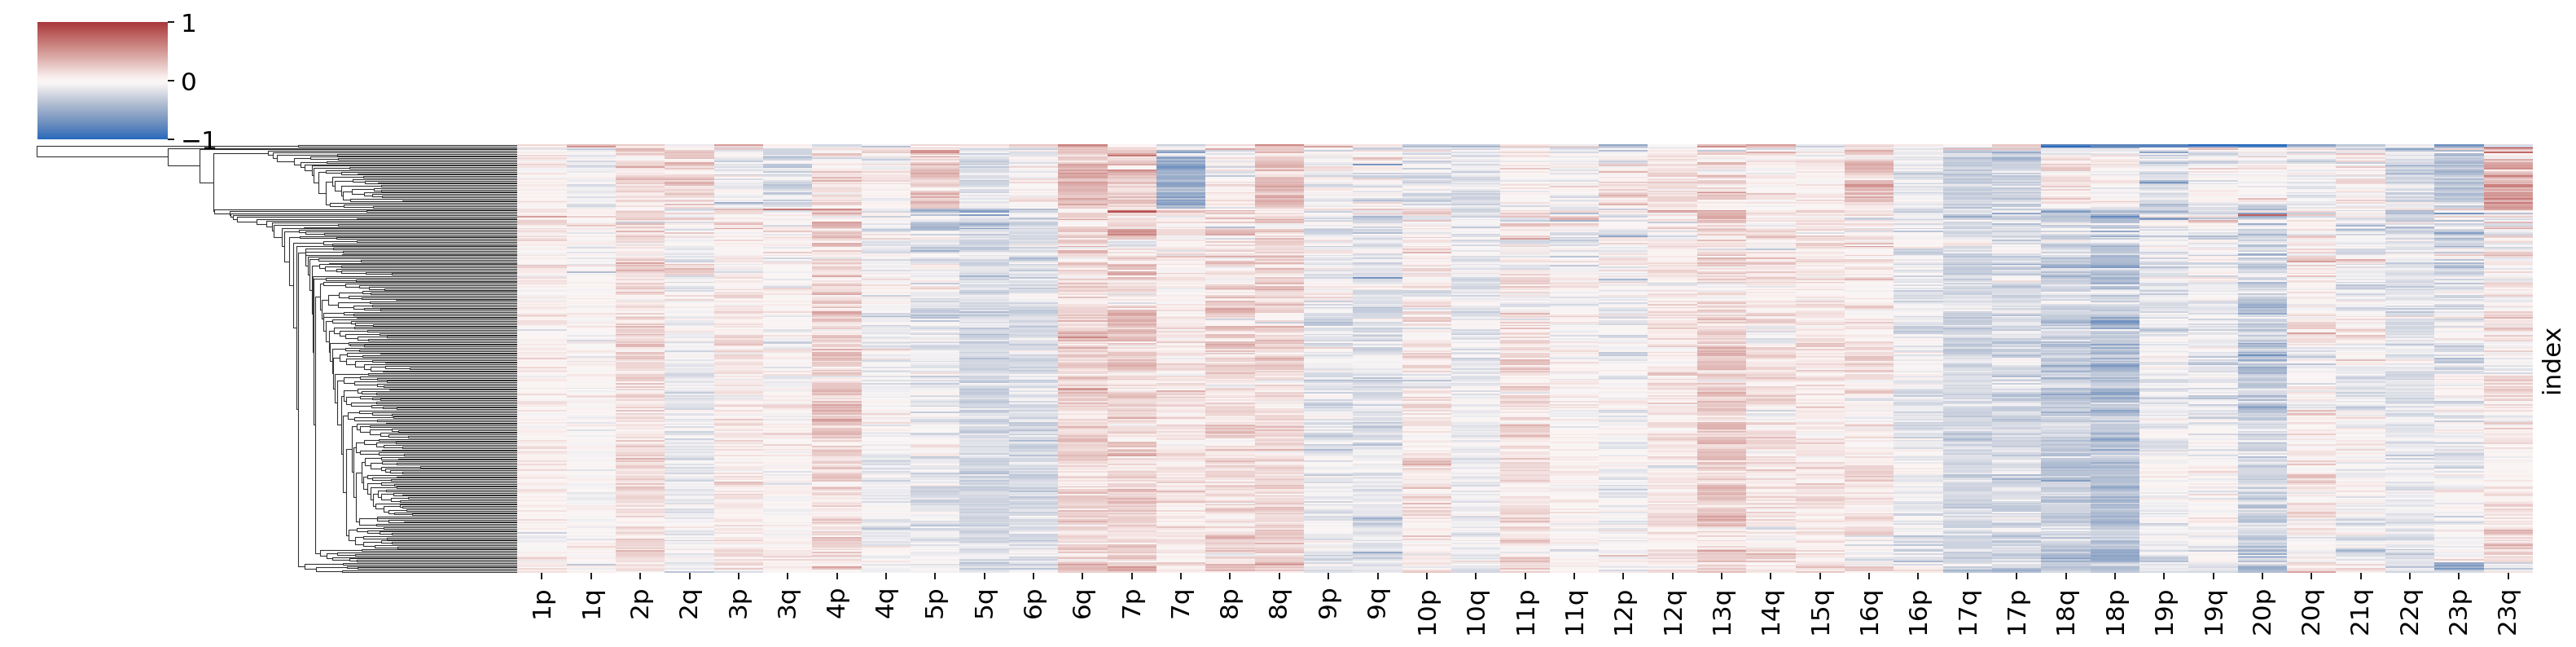

In [31]:
plot_cna(cna)

In [32]:
cna.to_csv("cna_test.csv")

In [23]:
t = pd.read_csv("cna_test.csv")

NCIH2126_LUNG


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

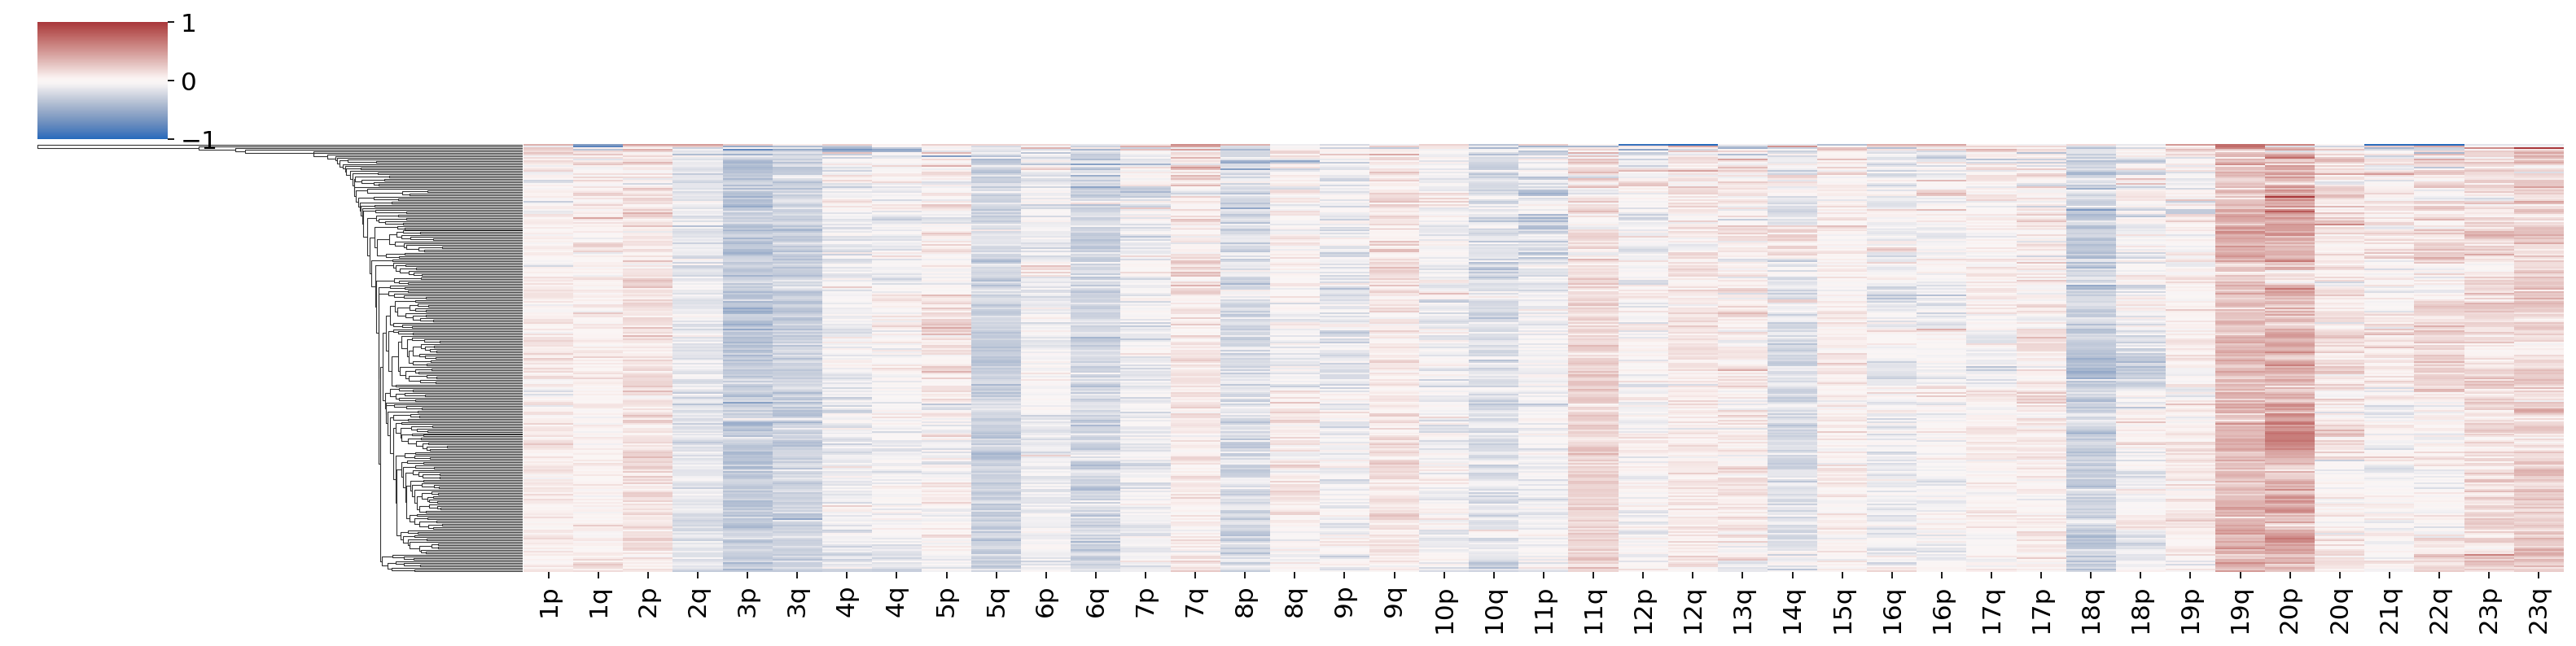

SW579_THYROID


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

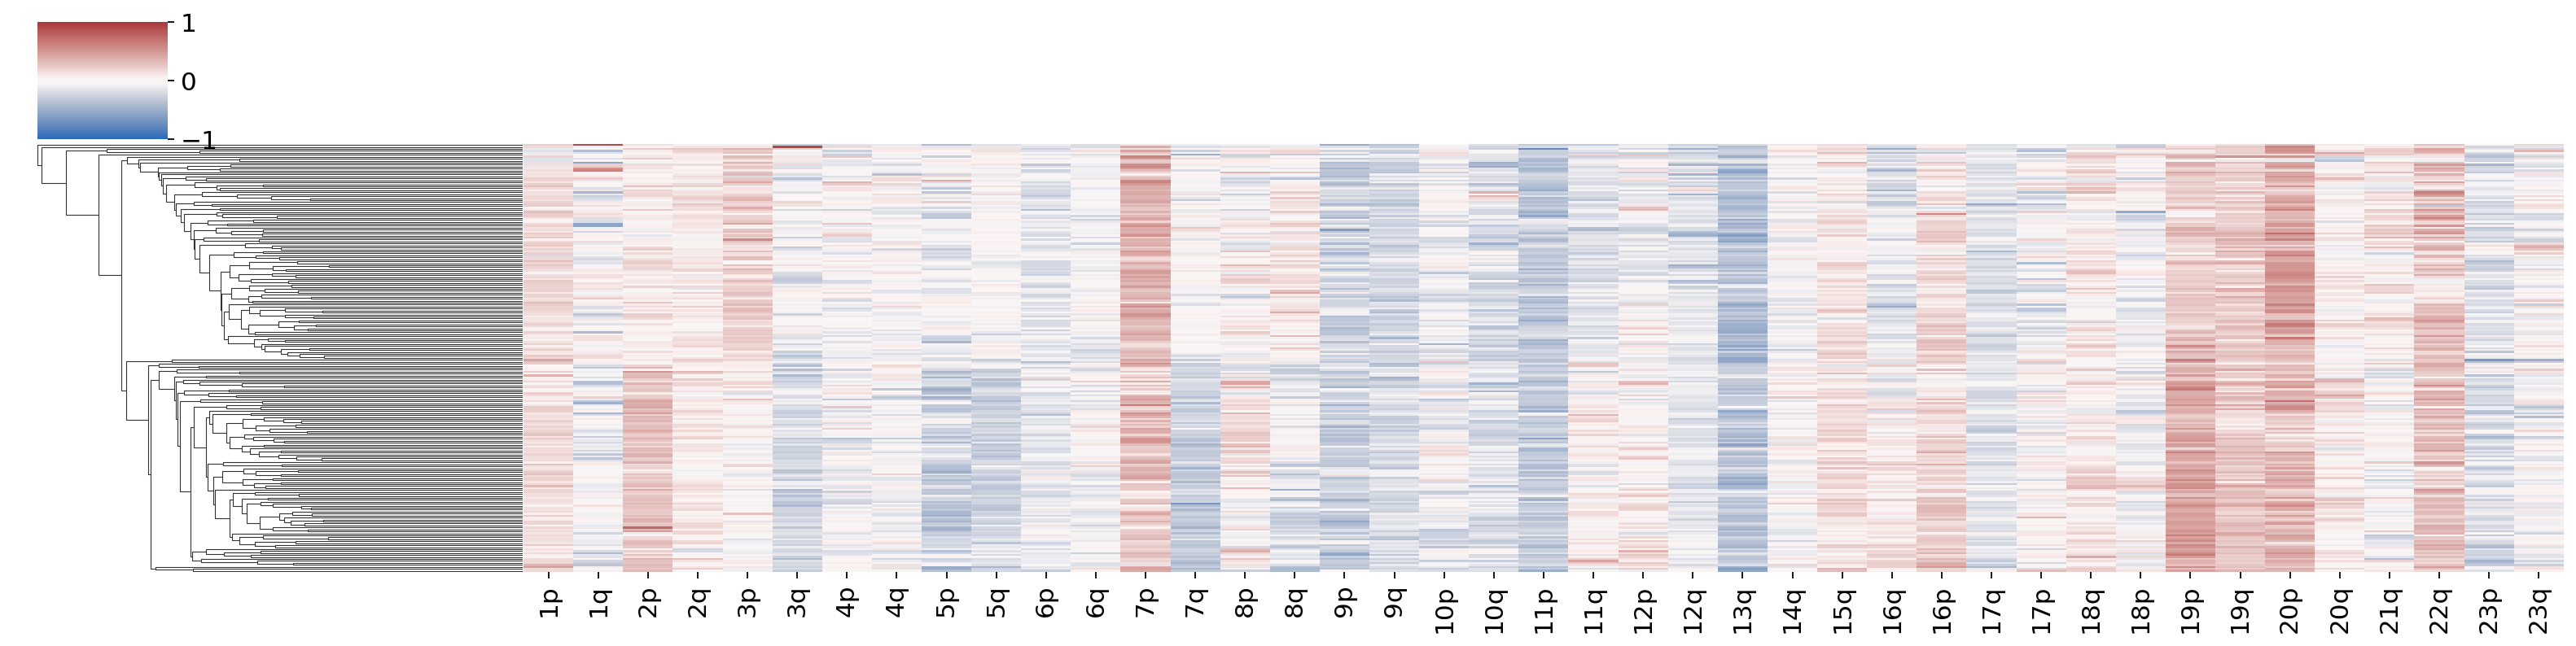

C32_SKIN


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

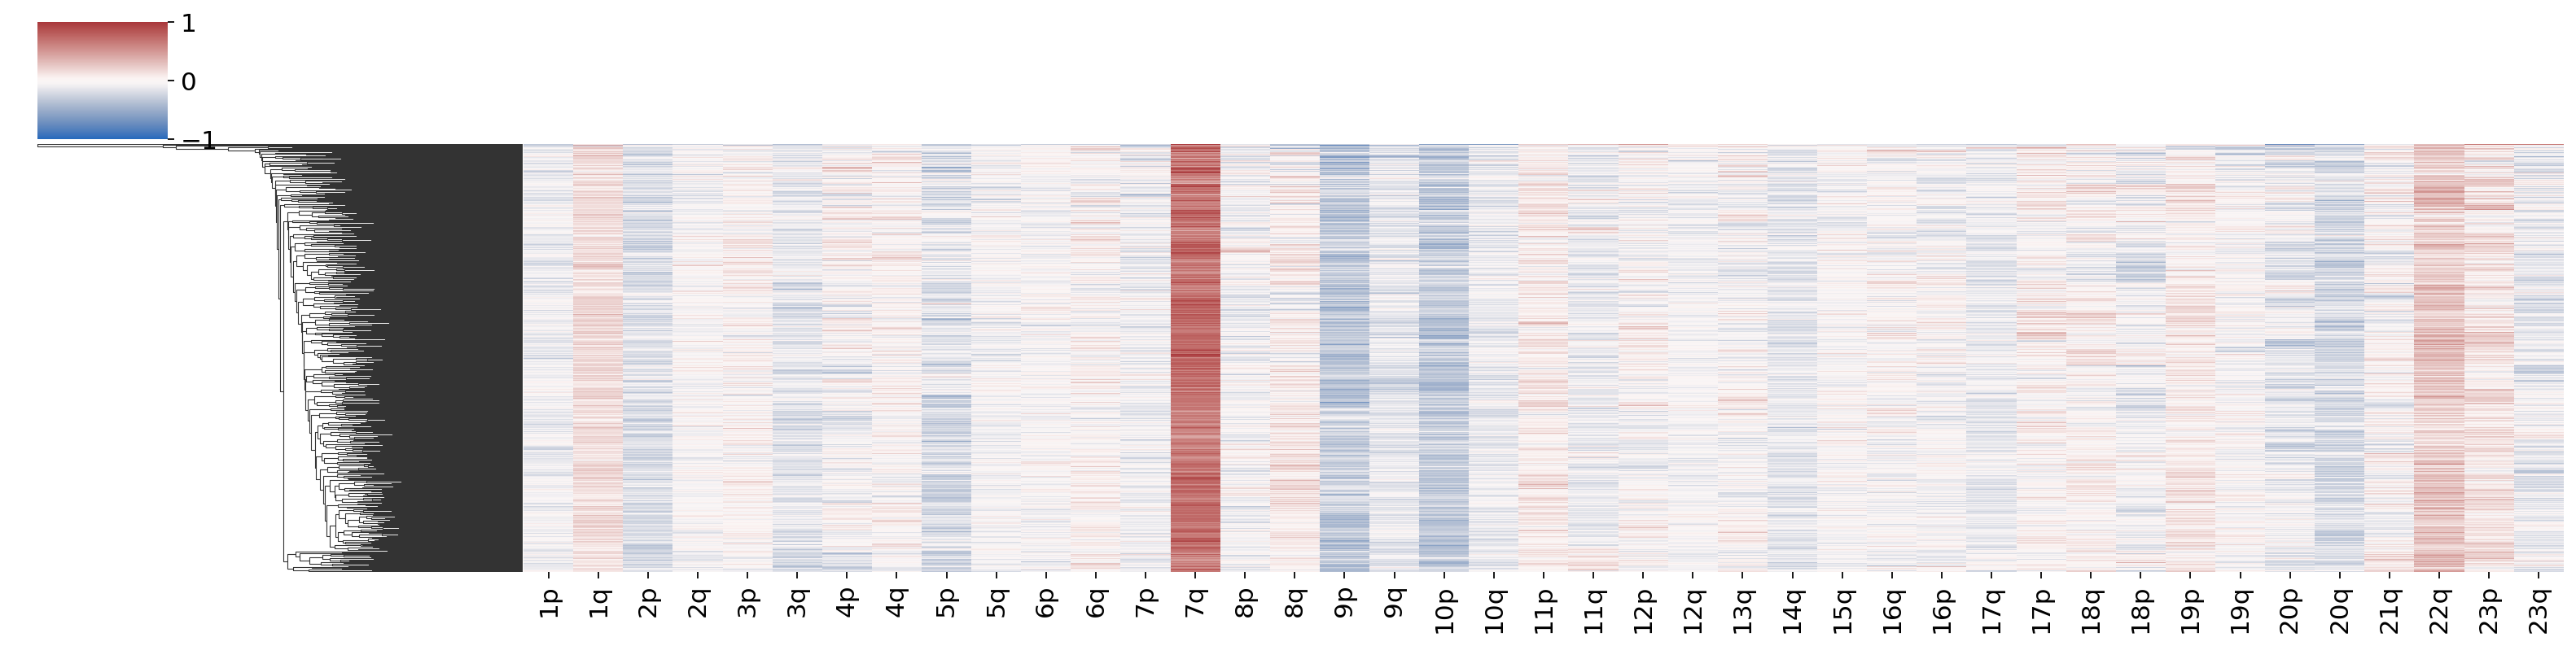

NCIH446_LUNG


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

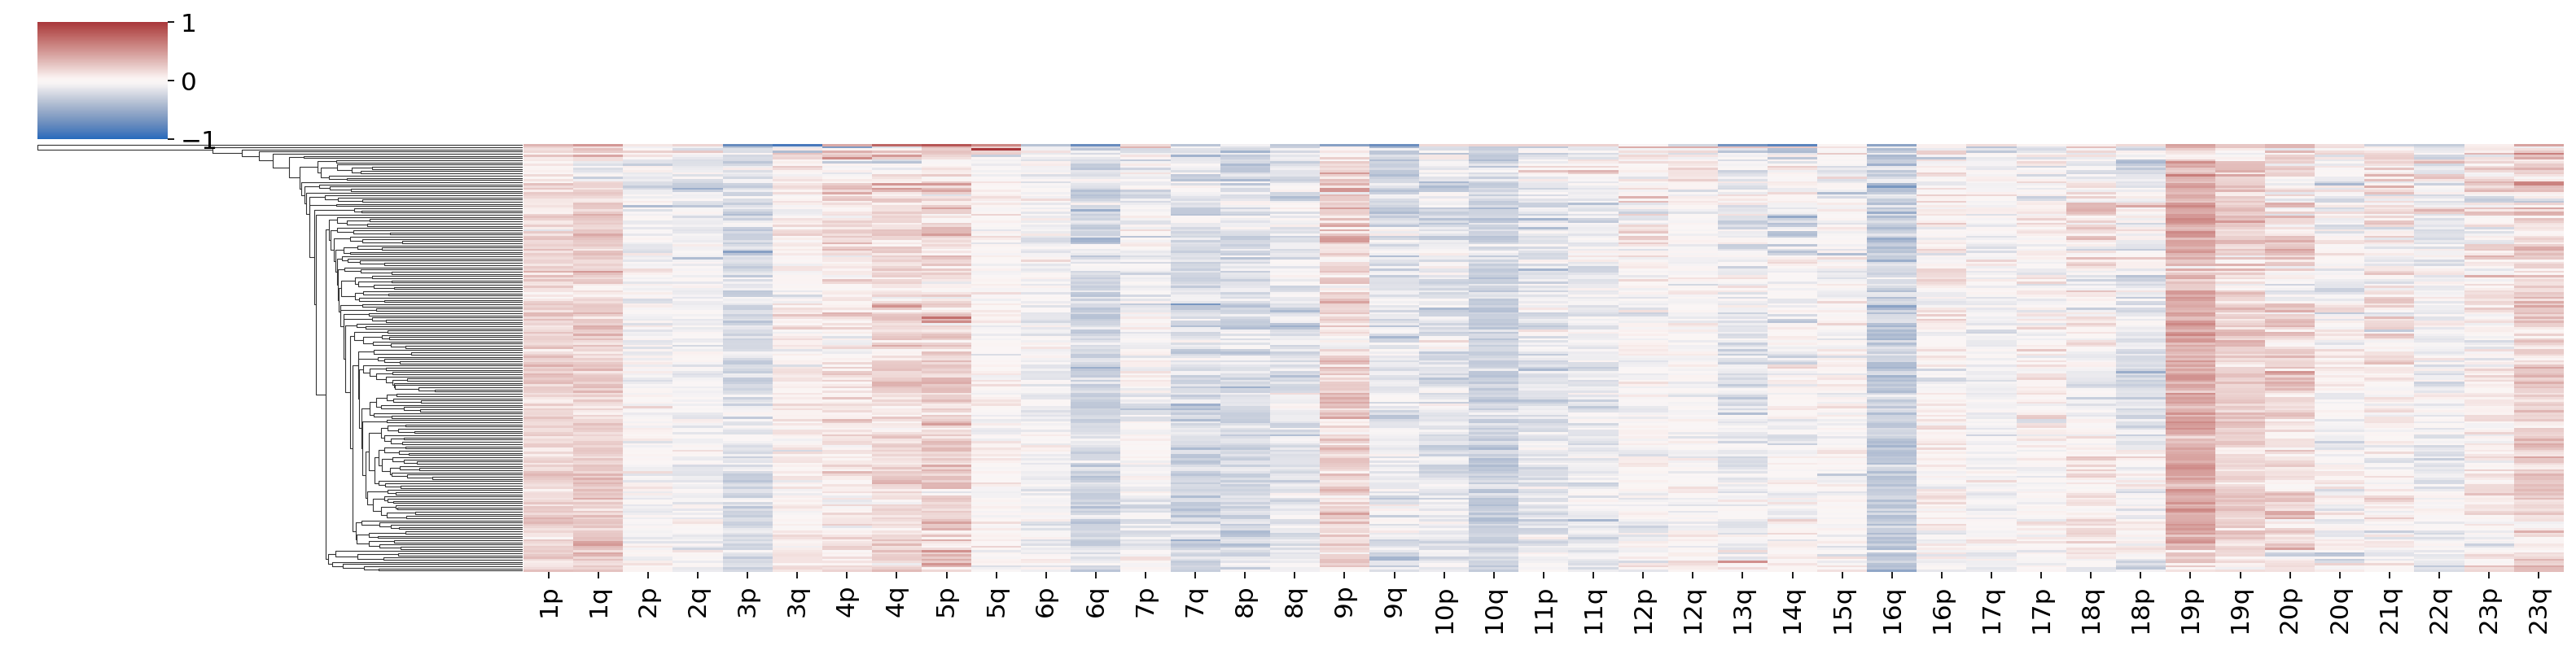

HEC251_ENDOMETRIUM


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

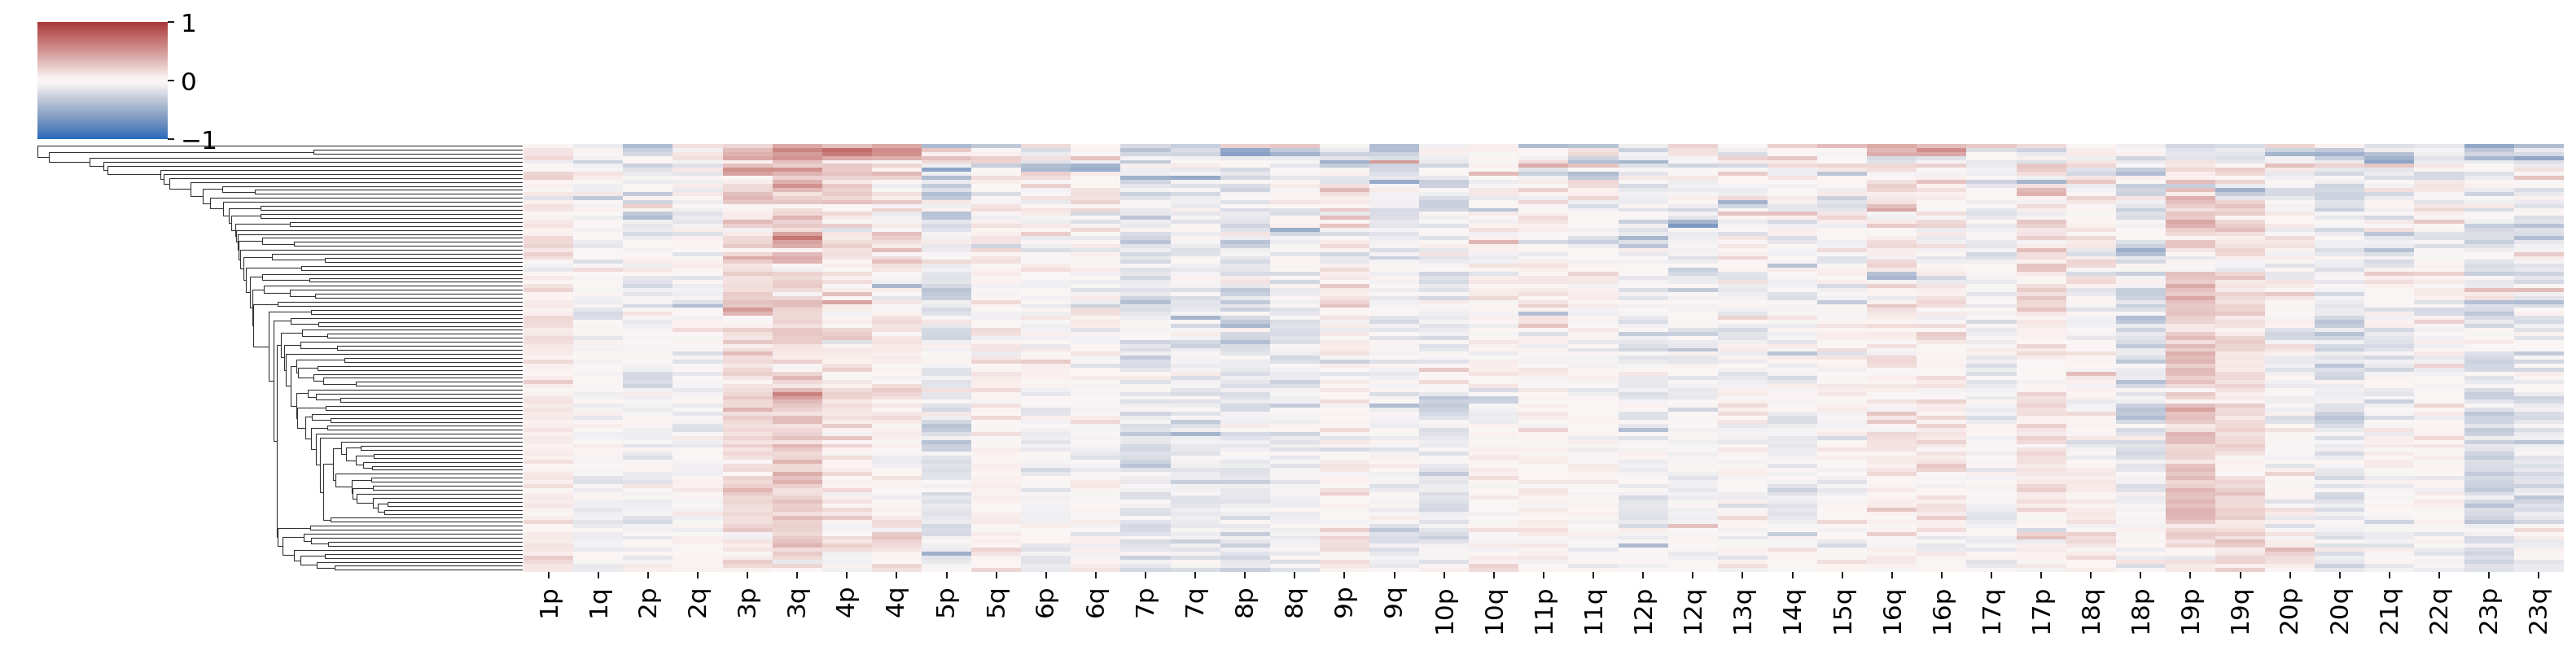

MFE319_ENDOMETRIUM


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

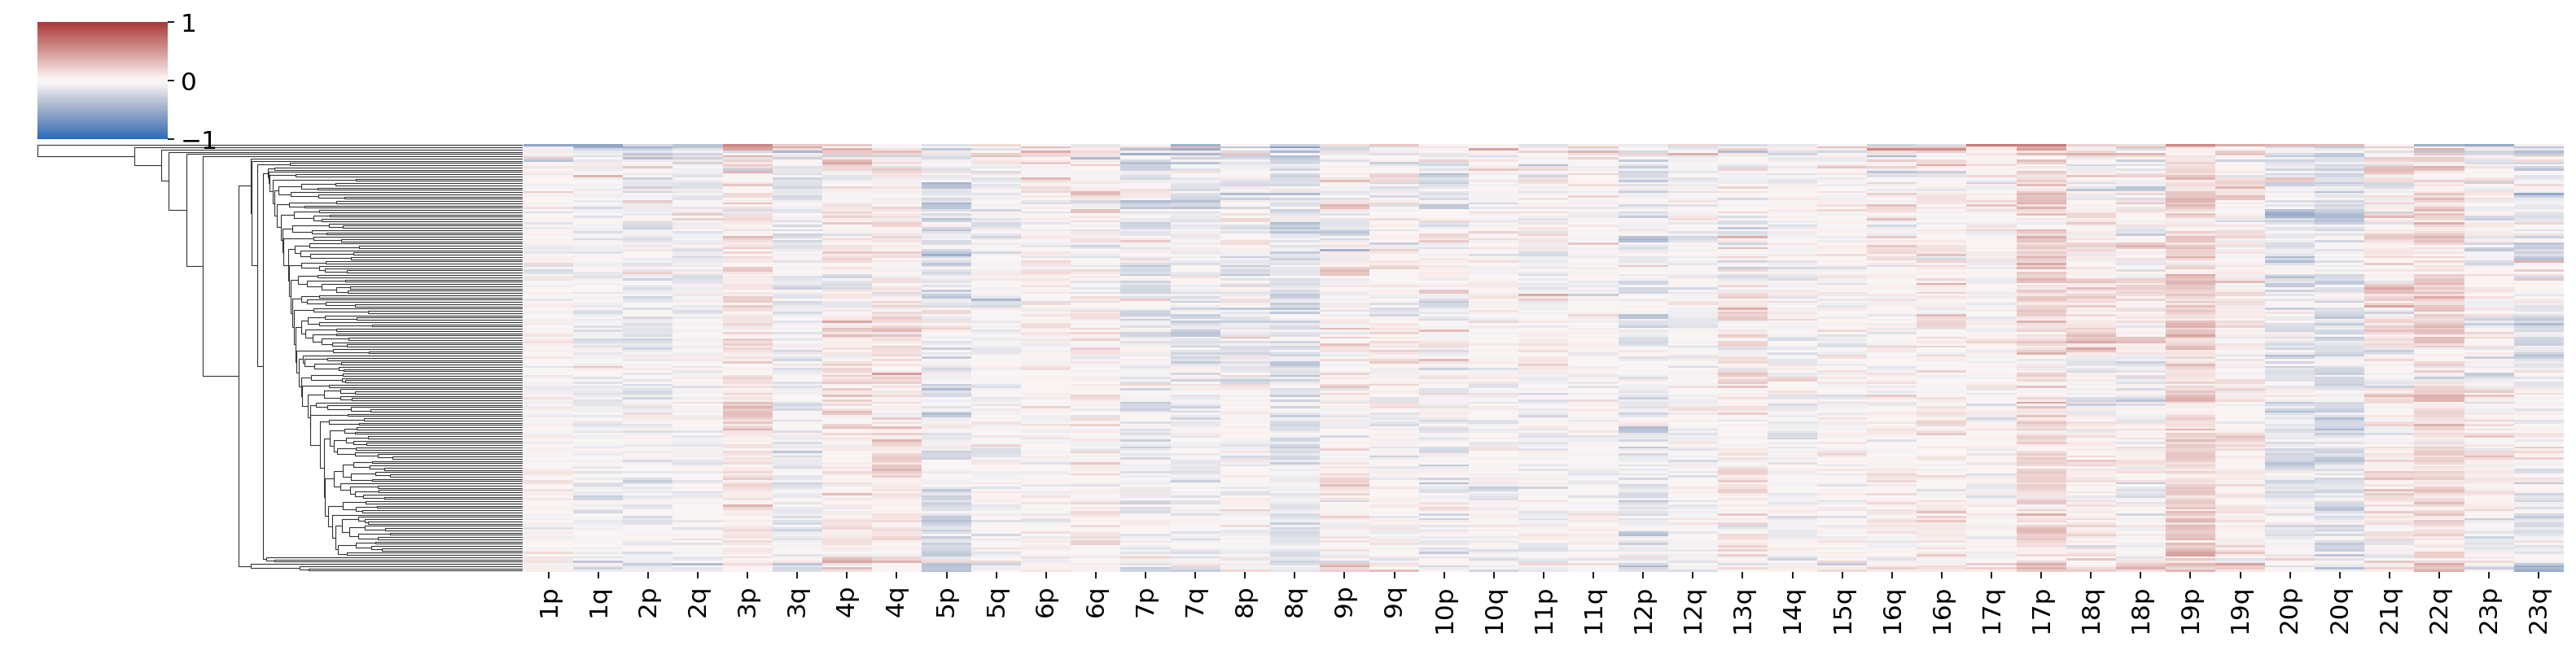

SKNAS_AUTONOMIC_GANGLIA


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

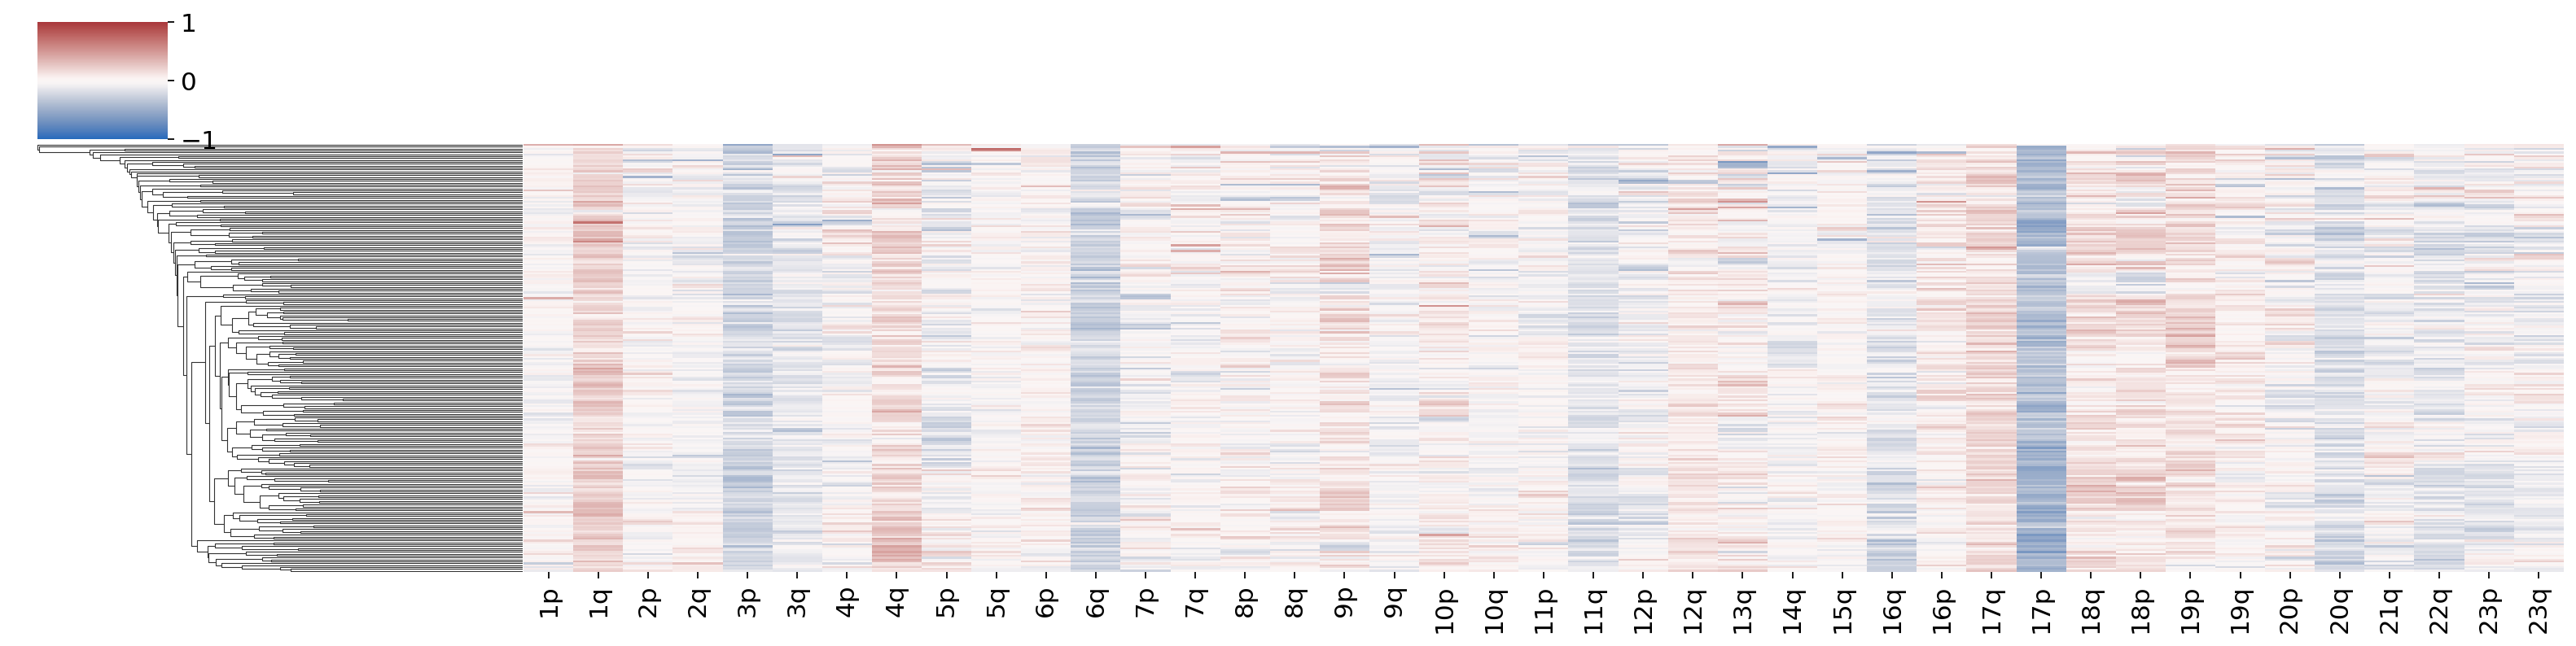

NCIH2452_PLEURA


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

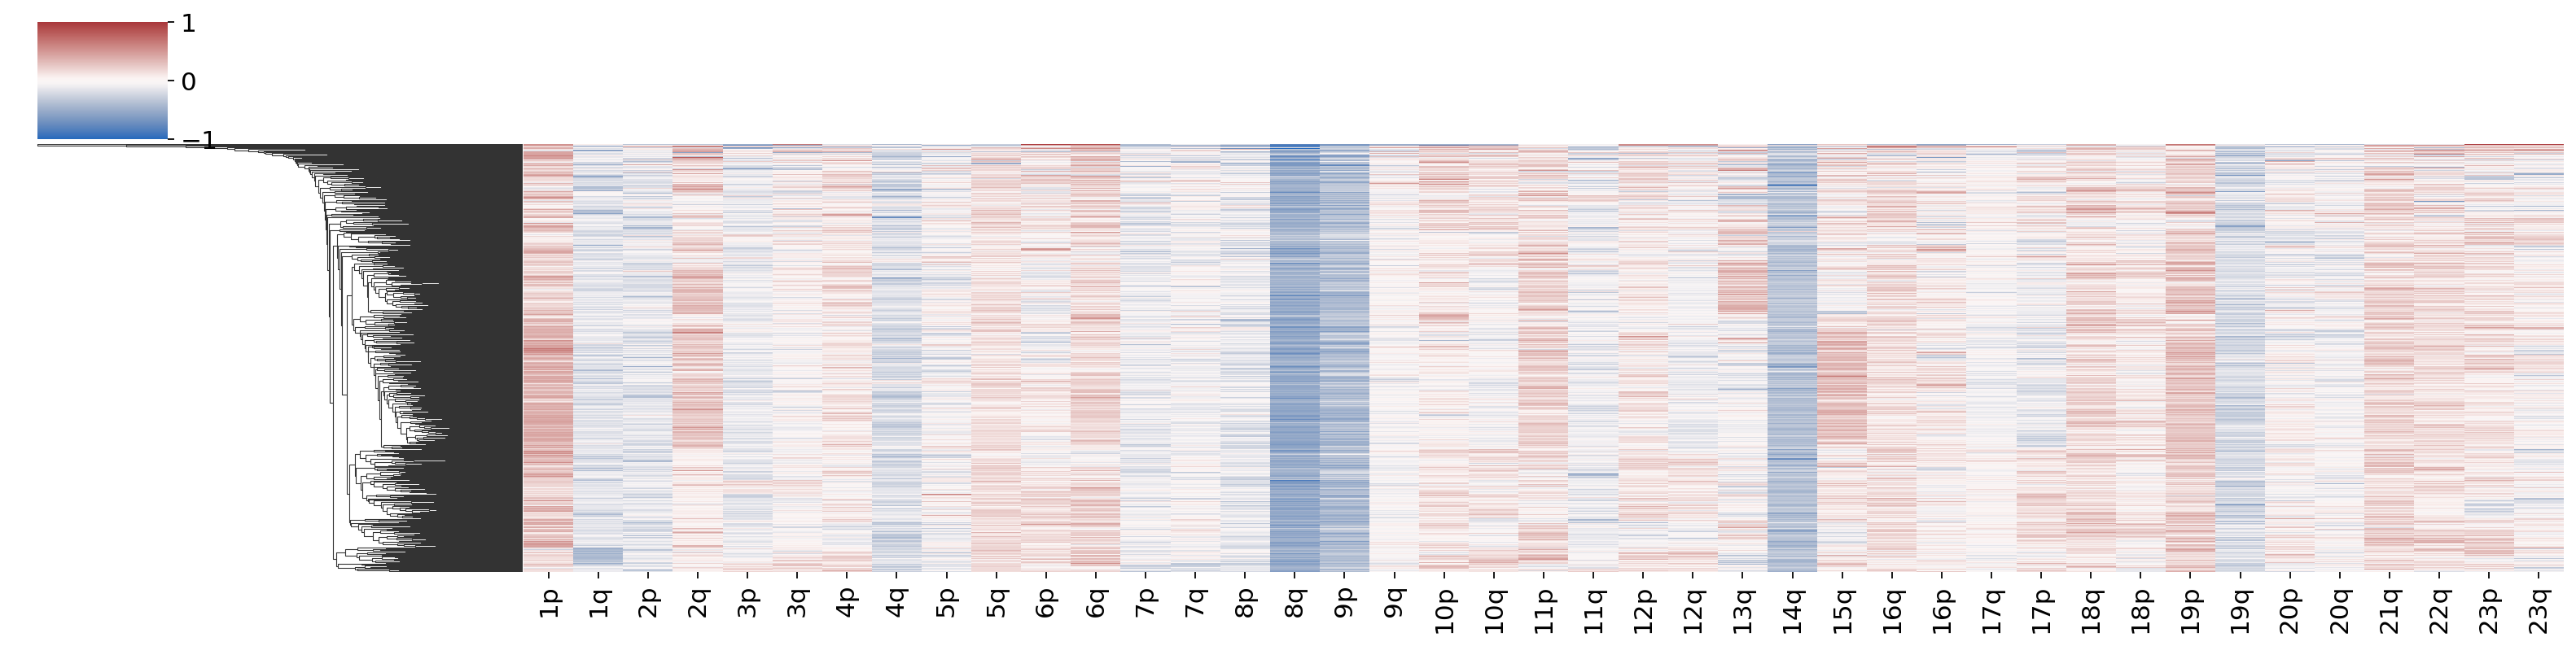

COLO741_SKIN


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

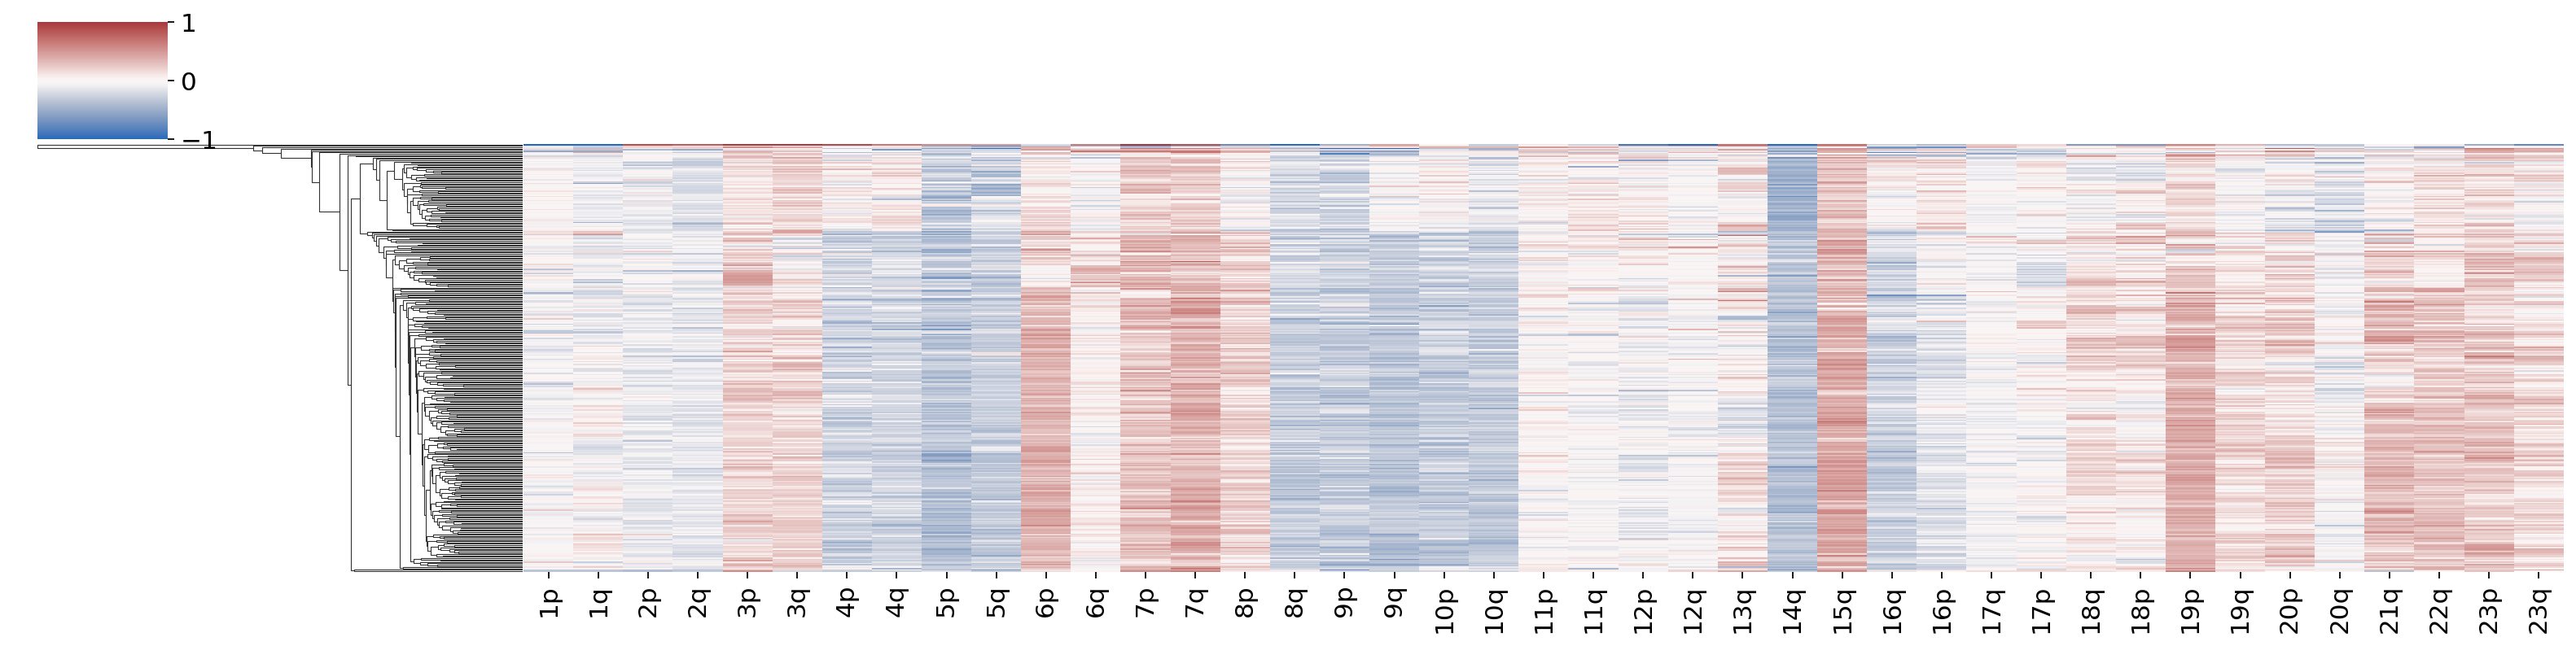

WM88_SKIN


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

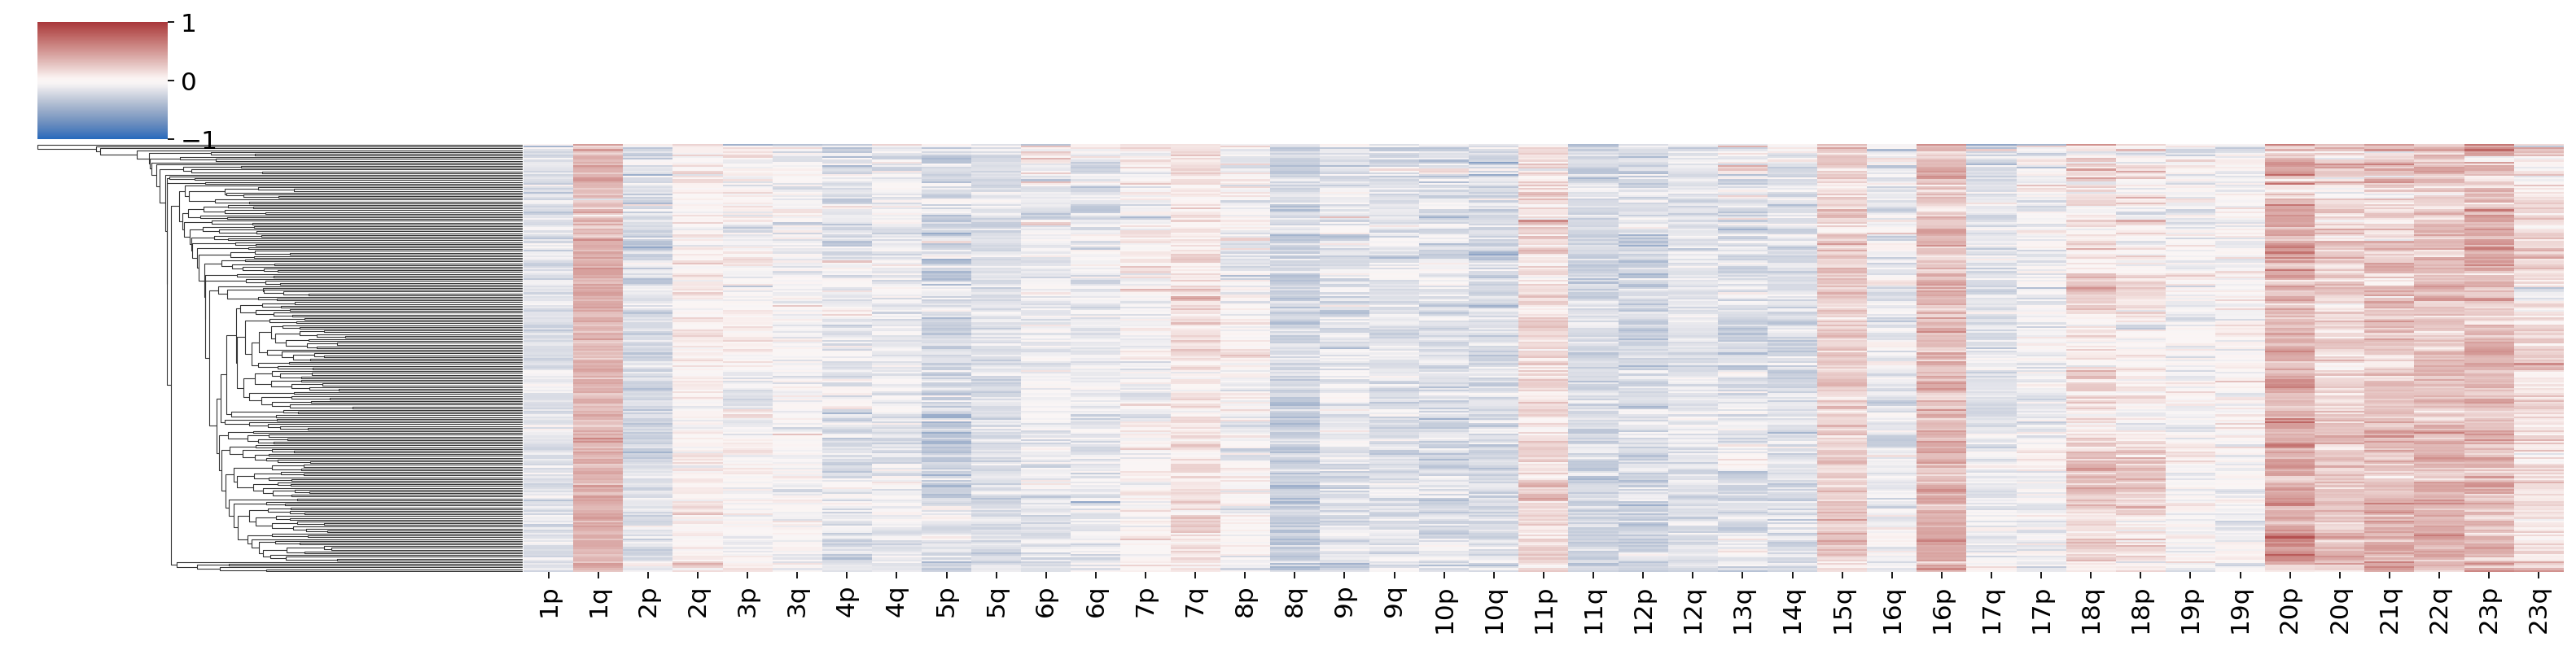

JHH7_LIVER


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

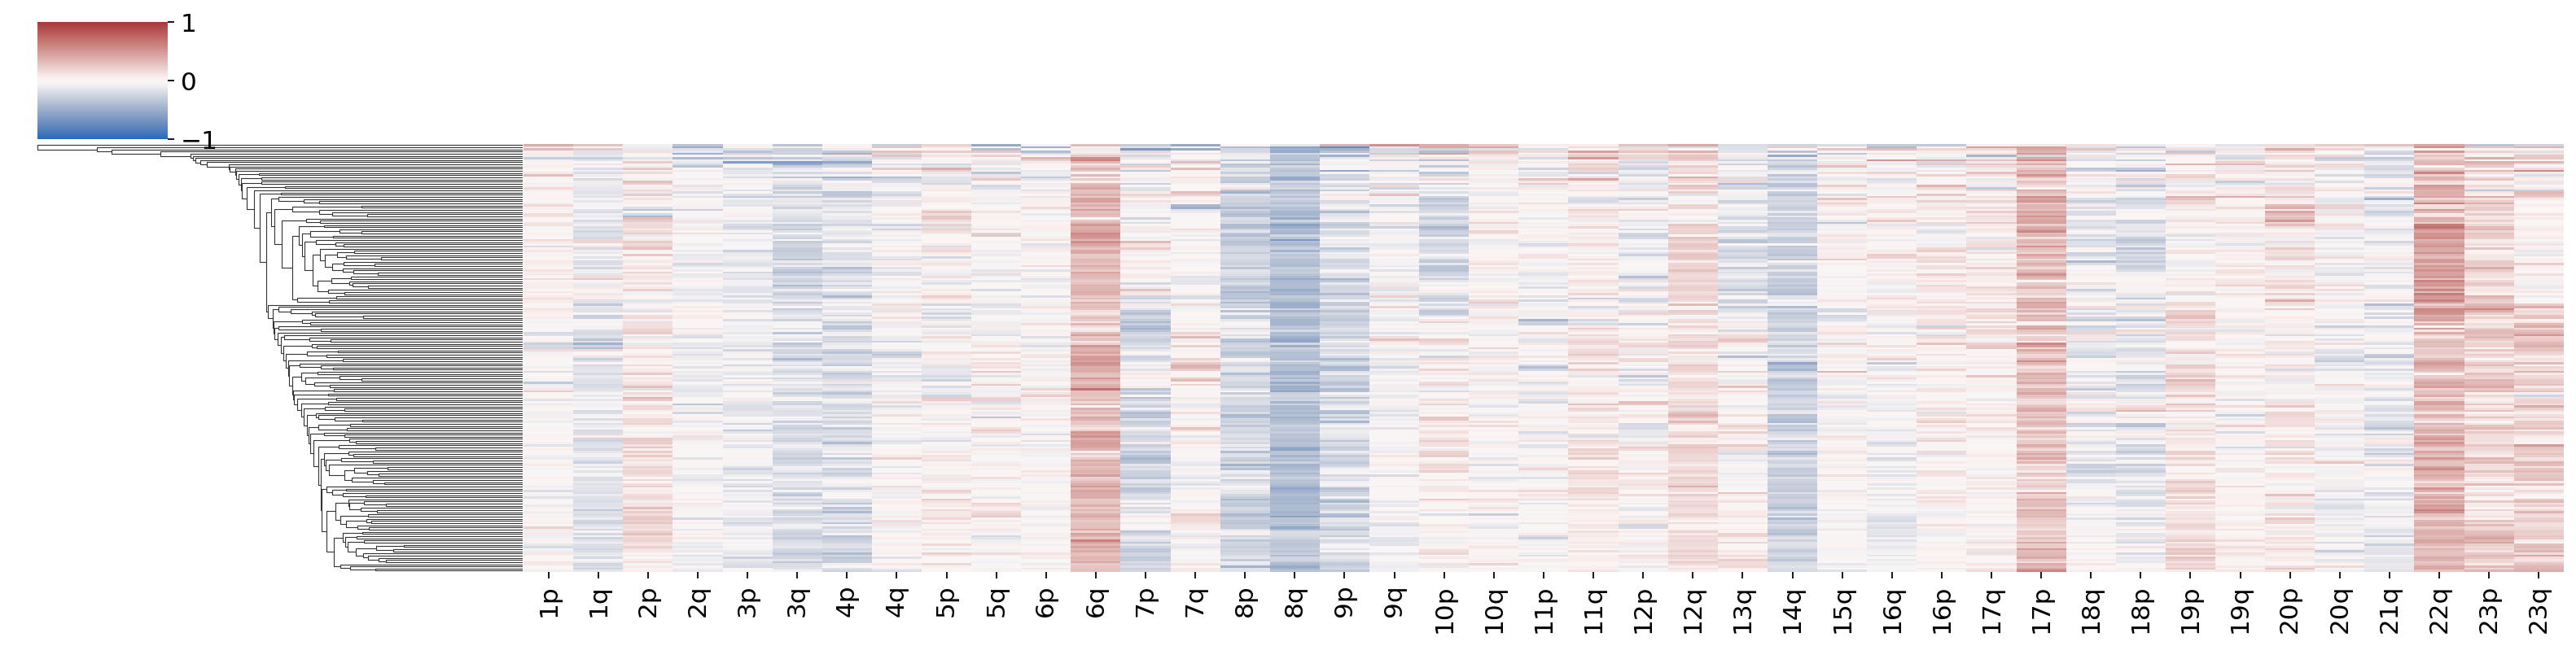

KNS42_CENTRAL_NERVOUS_SYSTEM


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

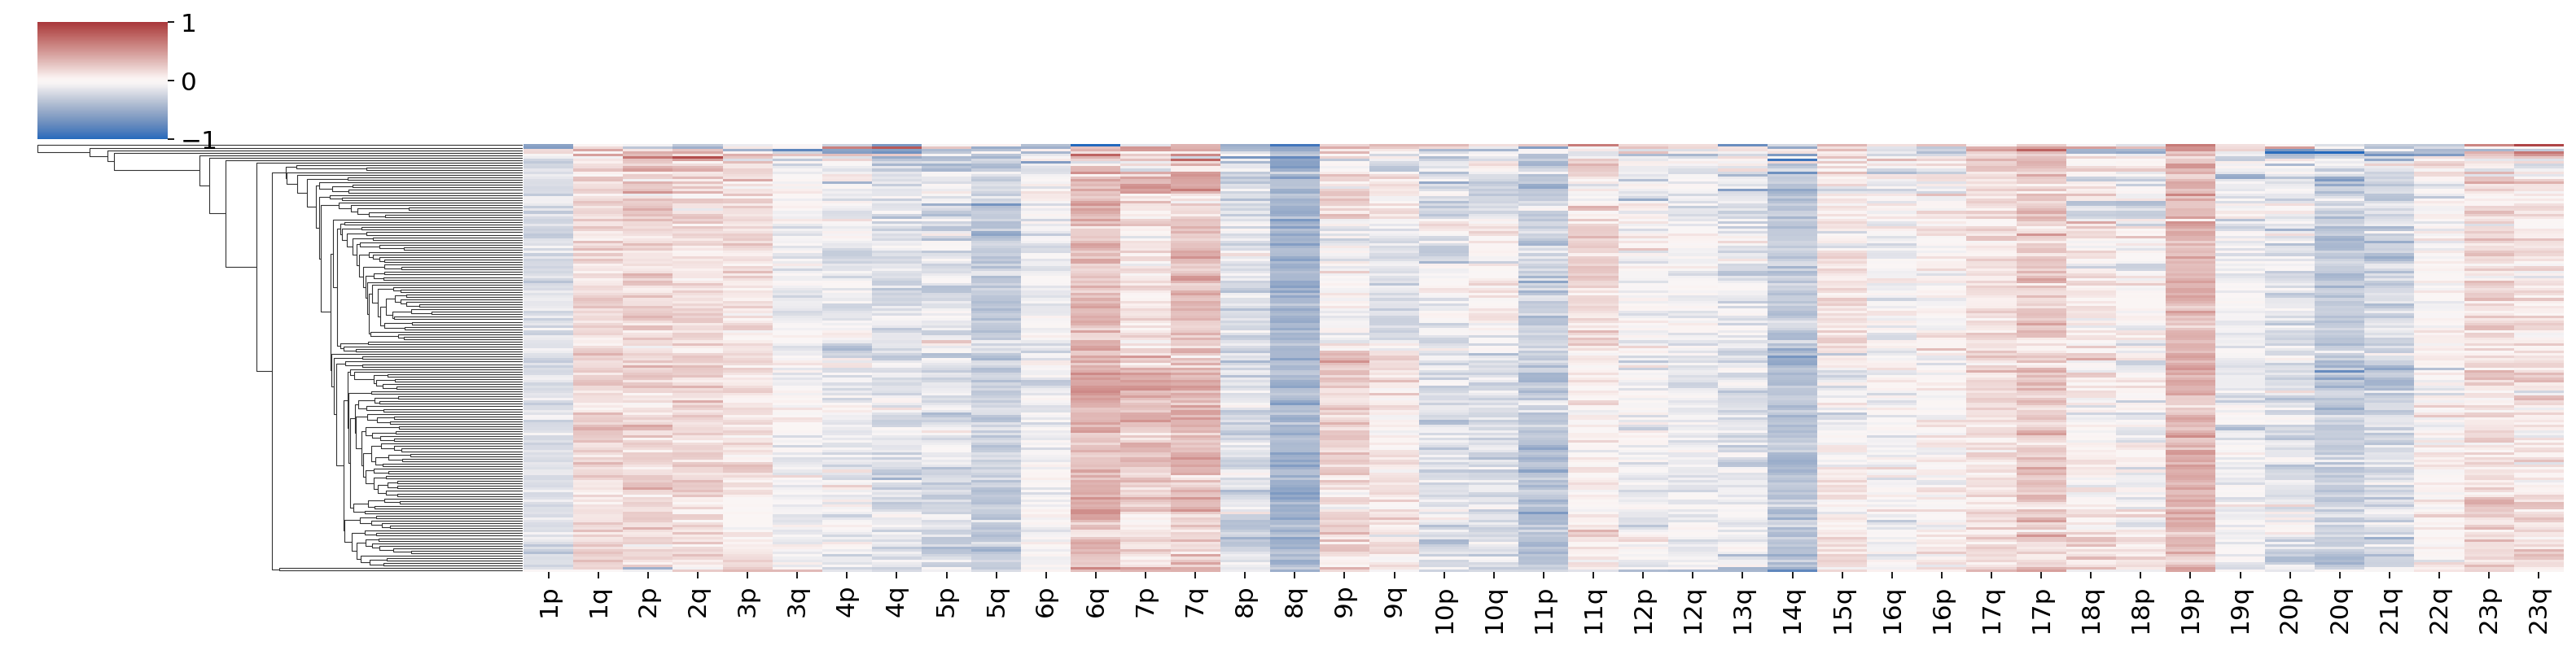

MCF7_BREAST


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

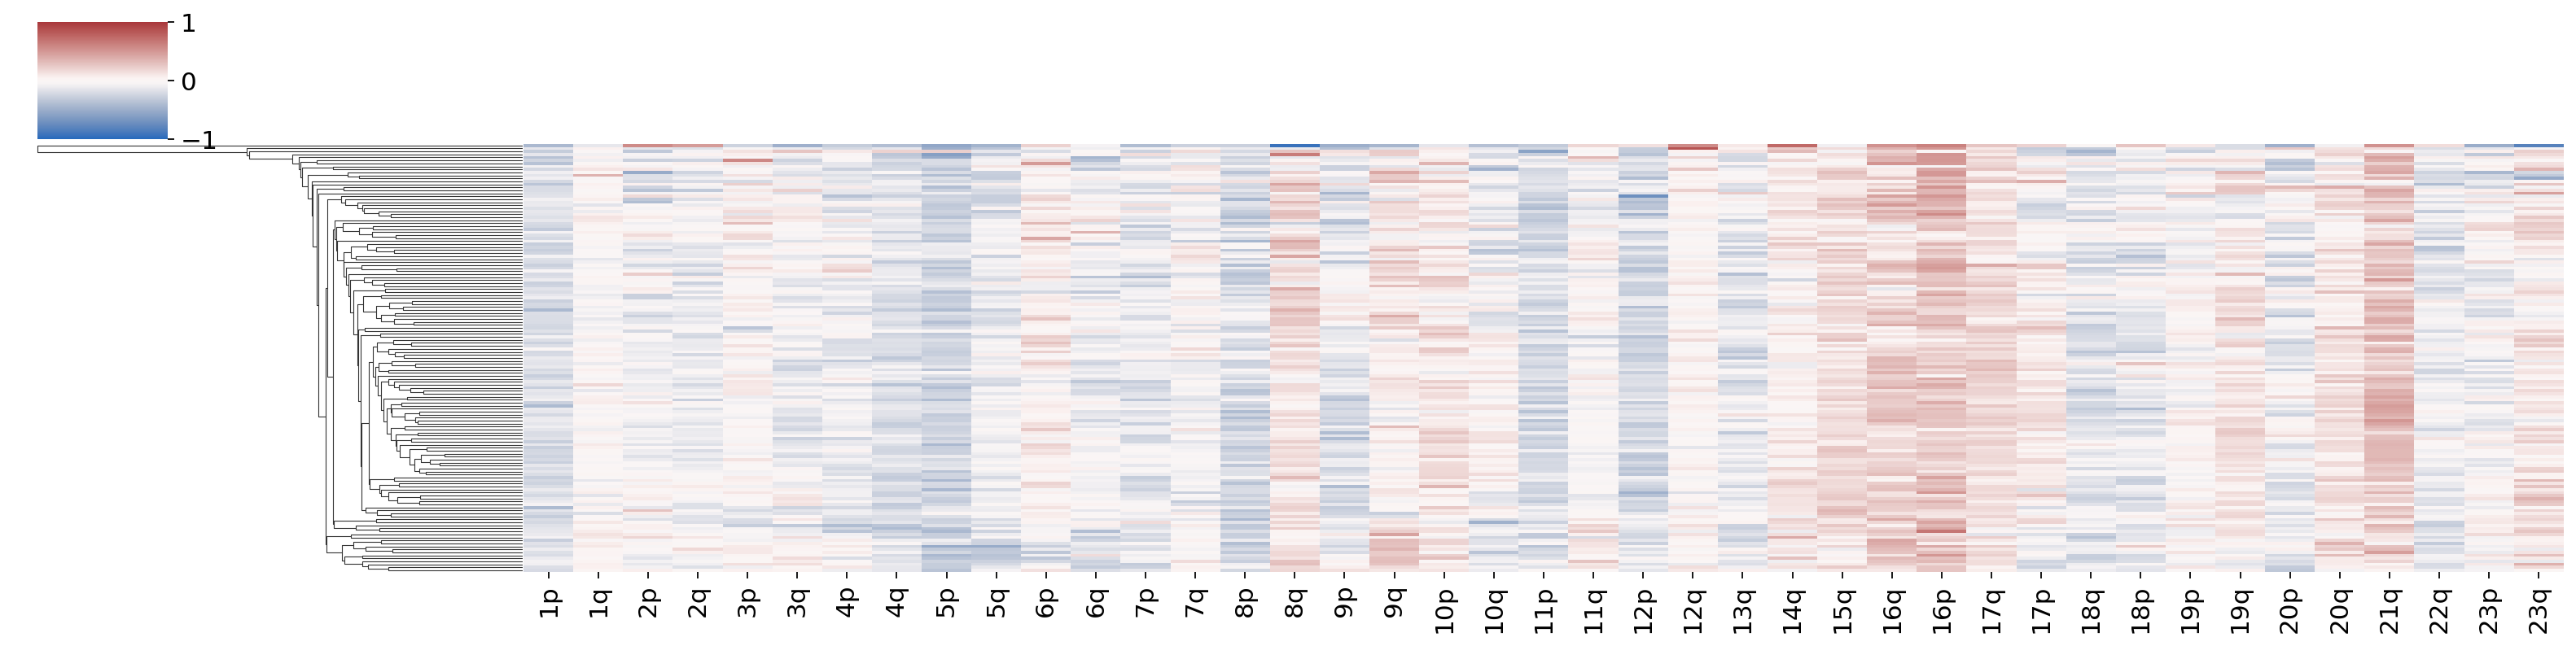

HT1197_URINARY_TRACT


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

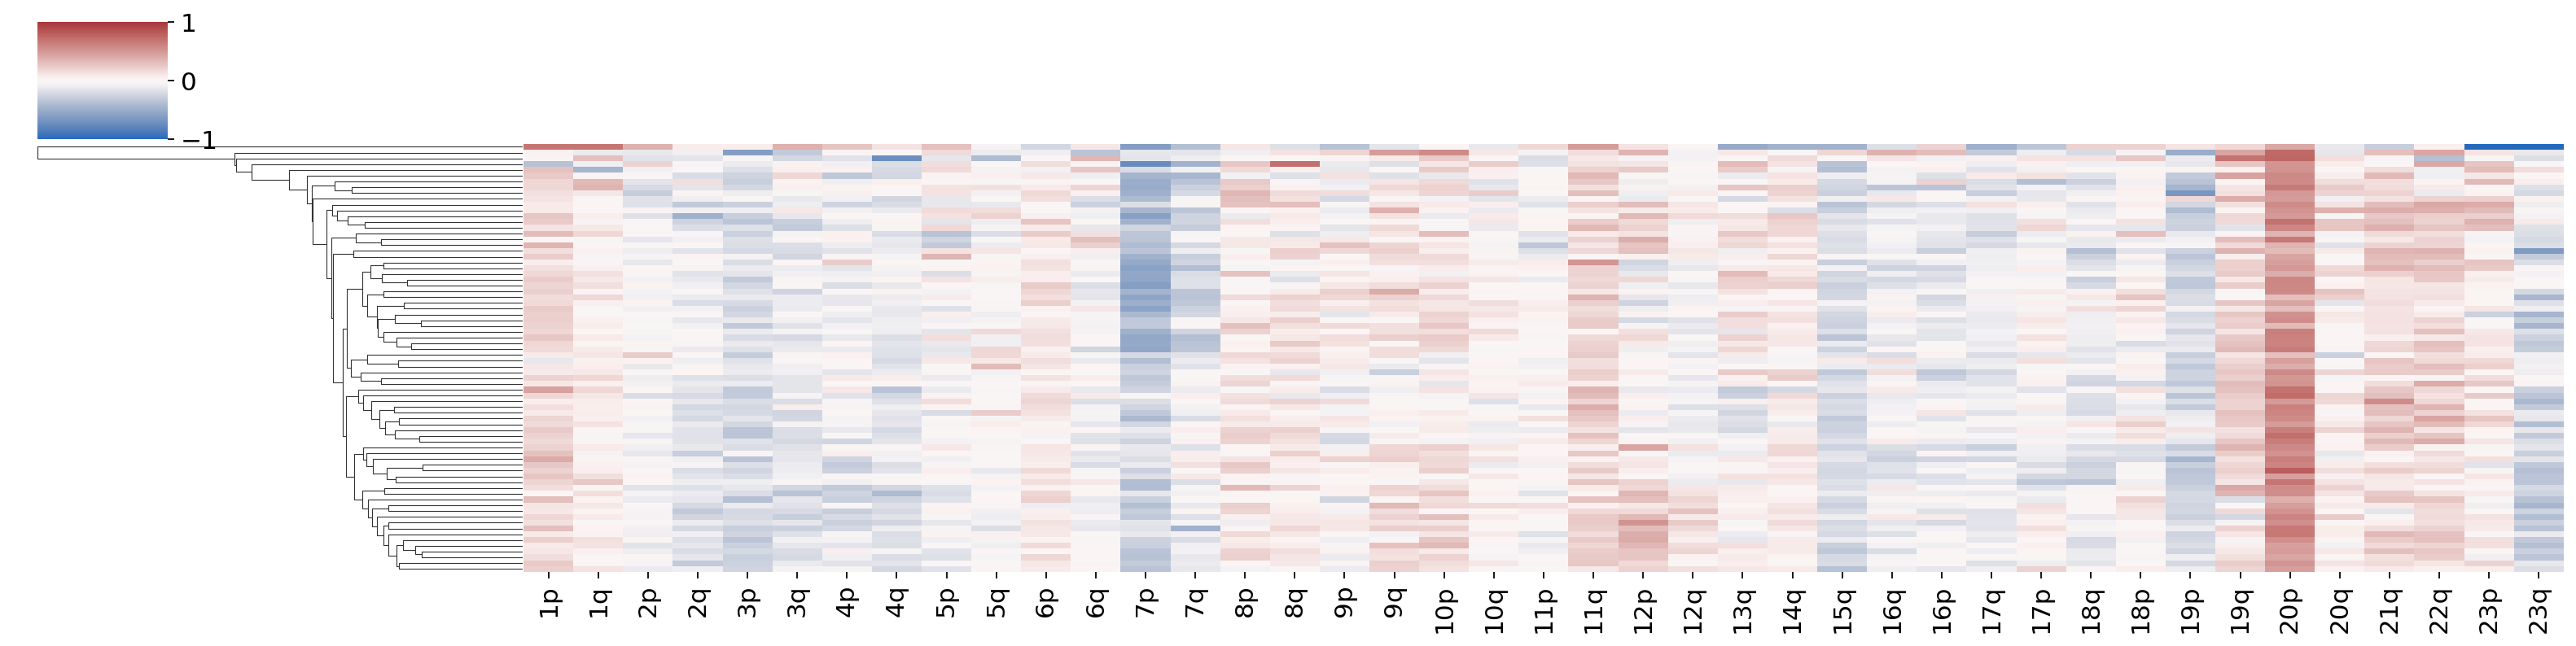

SNU899_UPPER_AERODIGESTIVE_TRACT


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

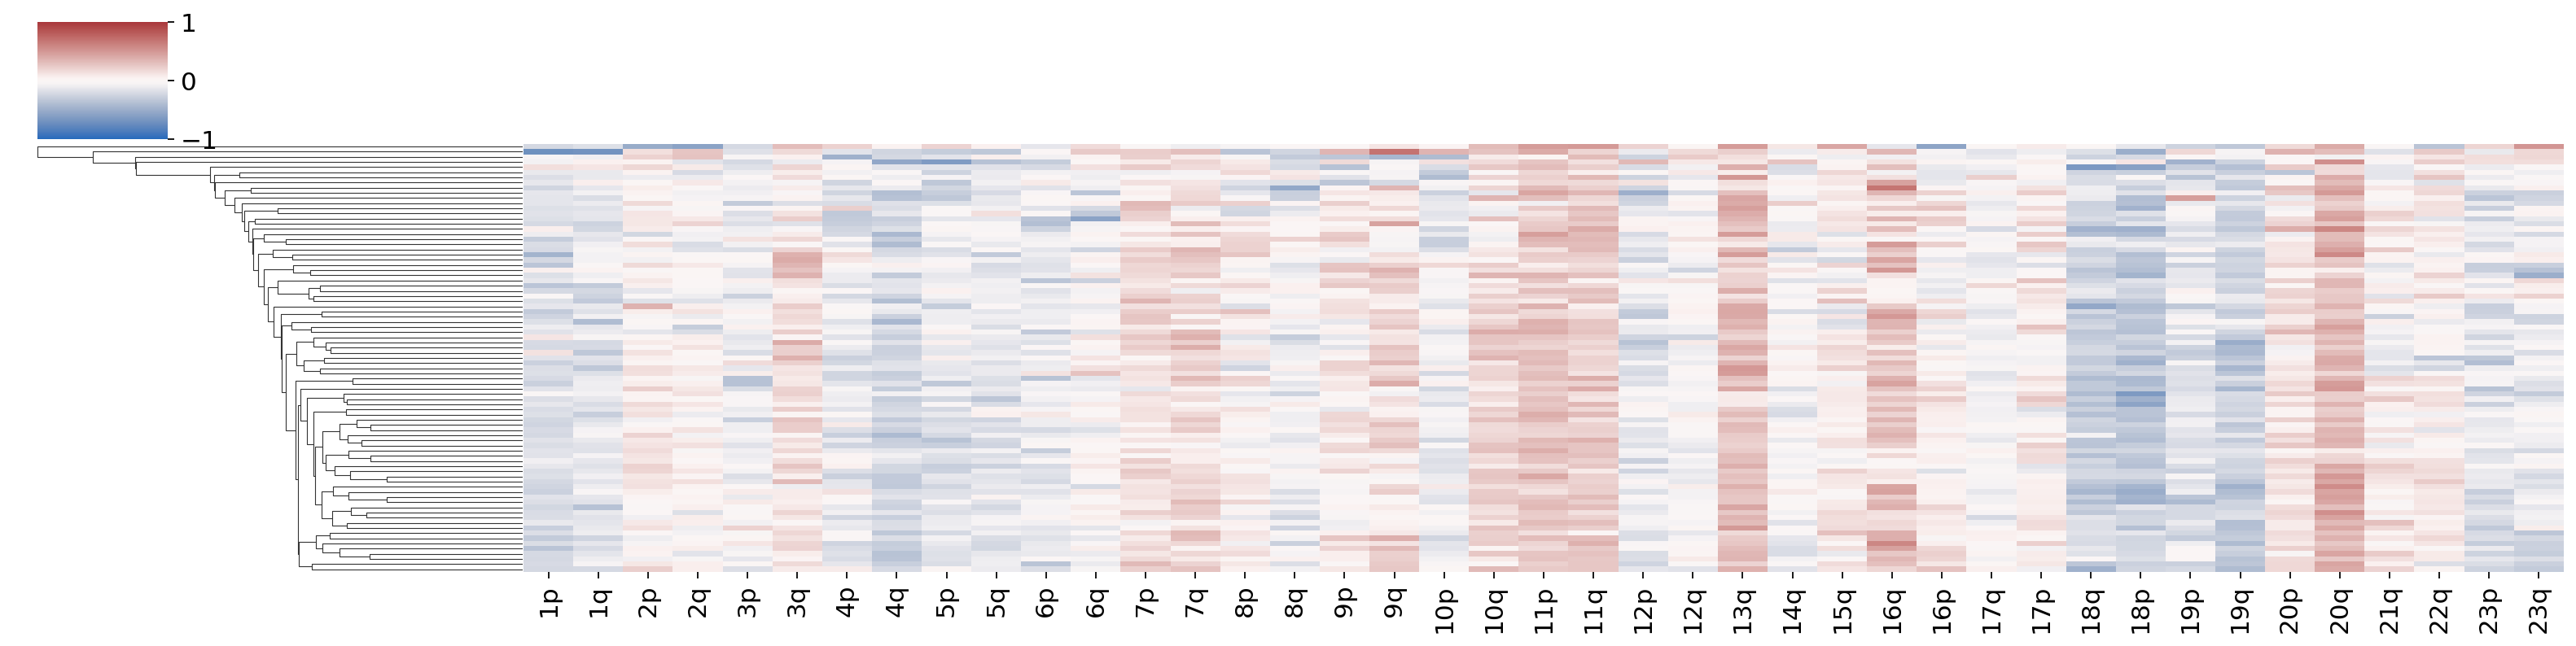

HCC38_BREAST


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [ ]:
for p in merge_adata.obs['CCLE_ID'].unique():
    
    print(p)
    cna = pd.read_csv(f"/mnt/{p}_cna.csv")
    plot_cna(cna)